<h2 style='color:blue' align='center'>采用VGG加深网络实现对cifar10数据集中事物的识别分类</h2>

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import time
import os
import ssl

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


![avatar](small_images.jpg)

CIFAR-10数据集是一个用于监督学习训练的数据集，由60000个样本组成，每个样本都是一张32*32像素的RGB图像，共有10个类别，分别是飞机（plane）、汽车（car）、鸟（bird）、猫（cat）、鹿（deer）、狗（dog）、青蛙（frog）、马（horse）、船（ship）和卡车（truck）。
以下是CIFAR-10数据集的出处链接：
[TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/cifar10)

In [2]:
#数据预处理
transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomGrayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform1 = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


In [3]:
# 数据集根目录
data_root = '/kaggle/input/cifar-10-batches-py-tar-gz/'

# 训练集
trainset = torchvision.datasets.CIFAR10(root=data_root, train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

# 测试集
testset = torchvision.datasets.CIFAR10(root=data_root, train=False, download=True, transform=transform1)
testloader = torch.utils.data.DataLoader(testset, batch_size=50, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# VGG加深网络
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()

        self.conv5 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv6 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv7 = nn.Conv2d(128, 128, 1, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()

        self.conv8 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv9 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv10 = nn.Conv2d(256, 256, 1, padding=1)
        self.pool4 = nn.MaxPool2d(2, 2, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU()

        self.conv11 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv12 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv13 = nn.Conv2d(512, 512, 1, padding=1)
        self.pool5 = nn.MaxPool2d(2, 2, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.relu5 = nn.ReLU()

        self.fc14 = nn.Linear(512 * 4 * 4, 1024)
        self.drop = nn.Dropout()
        self.fc15 = nn.Linear(1024, 1024)
        self.fc16 = nn.Linear(1024, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.pool3(x)
        x = self.bn3(x)
        x = self.relu3(x)

        x = self.conv8(x)
        x = self.conv9(x)
        x = self.conv10(x)
        x = self.pool4(x)
        x = self.bn4(x)
        x = self.relu4(x)

        x = self.conv11(x)
        x = self.conv12(x)
        x = self.conv13(x)
        x = self.pool5(x)
        x = self.bn5(x)
        x = self.relu5(x)
        # print(" x shape ",x.size())
        x = x.view(-1, 512 * 4 * 4)
        x = F.relu(self.fc14(x))
        x = self.drop(x)
        x = F.relu(self.fc15(x))
        x = self.drop(x)
        x = self.fc16(x)

        return x

    def train_sgd(self, device):

        optimizer = optim.SGD(self.parameters(), lr=0.01)
        path = 'weights.tar'
        initepoch = 0

        if os.path.exists(path) is not True:
            loss = nn.CrossEntropyLoss()


        else:
            checkpoint = torch.load(path)
            self.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            initepoch = checkpoint['epoch']
            loss = checkpoint['loss']

        for epoch in range(initepoch, 10):  # loop over the dataset multiple times
            timestart = time.time()

            running_loss = 0.0
            total = 0
            correct = 0
            for i, data in enumerate(trainloader, 0):
                # get the inputs
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                outputs = self(inputs)
                l = loss(outputs, labels)
                l.backward()
                optimizer.step()

                running_loss += l.item()

                if i % 500 == 499:
                    print('[%d, %5d] loss: %.4f' %
                          (epoch, i, running_loss / 500))
                    running_loss = 0.0
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    print('Accuracy of the network on the %d tran images: %.3f %%' % (total,
                                                                                      100.0 * correct / total))
                    total = 0
                    correct = 0
                    torch.save({'epoch': epoch,
                                'model_state_dict': net.state_dict(),
                                'optimizer_state_dict': optimizer.state_dict(),
                                'loss': loss
                                }, path)
            
            print('epoch %d cost %3f sec' % (epoch, time.time() - timestart))

        print('Finished Training')

    def test(self, device):
        correct = 0
        total = 0
        with torch.no_grad():
            for data in testloader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = self(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print('Accuracy of the network on the 10000 test images: %.3f %%' % (100.0 * correct / total))

    def classify(self, device):
        class_correct = list(0. for i in range(10))
        class_total = list(0. for i in range(10))
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = self(images)
            _, predicted = torch.max(outputs.data, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i]
                class_total[label] += 1

        for i in range(10):
            print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))


In [5]:
if __name__ == '__main__':
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = Net()
    net = net.to(device)
    net.train_sgd(device)
    net.test(device)
    net.classify(device)

[0,   499] loss: 1.6305
Accuracy of the network on the 100 tran images: 65.000 %
epoch 0 cost 31.607714 sec
[1,   499] loss: 1.1163
Accuracy of the network on the 100 tran images: 67.000 %
epoch 1 cost 20.655787 sec
[2,   499] loss: 0.8751
Accuracy of the network on the 100 tran images: 81.000 %
epoch 2 cost 21.024824 sec
[3,   499] loss: 0.7361
Accuracy of the network on the 100 tran images: 74.000 %
epoch 3 cost 21.613010 sec
[4,   499] loss: 0.6353
Accuracy of the network on the 100 tran images: 87.000 %
epoch 4 cost 22.149005 sec
[5,   499] loss: 0.5694
Accuracy of the network on the 100 tran images: 81.000 %
epoch 5 cost 22.651649 sec
[6,   499] loss: 0.5116
Accuracy of the network on the 100 tran images: 87.000 %
epoch 6 cost 22.349708 sec
[7,   499] loss: 0.4673
Accuracy of the network on the 100 tran images: 79.000 %
epoch 7 cost 22.189776 sec
[8,   499] loss: 0.4233
Accuracy of the network on the 100 tran images: 83.000 %
epoch 8 cost 22.313631 sec
[9,   499] loss: 0.3902
Accu

为了模型的评估比较，我们将尝试用ANN和CNN实现分类

In [6]:
# 初始化空列表用于存储所有数据
X_train, y_train = [], []

# 遍历所有训练集数据
for batch_X, batch_y in trainloader:
    X_train.append(batch_X)
    y_train.append(batch_y)

# 将列表中的 Tensor 拼接成一个整体
X_train = torch.cat(X_train, dim=0)
y_train = torch.cat(y_train, dim=0)

# 打印样本形状
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape: torch.Size([50000, 3, 32, 32])
y_train shape: torch.Size([50000])


In [7]:
# 同样方式处理测试集
X_test, y_test = [], []

for batch_X, batch_y in testloader:
    X_test.append(batch_X)
    y_test.append(batch_y)

X_test = torch.cat(X_test, dim=0)
y_test = torch.cat(y_test, dim=0)

# 打印样本形状
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_test shape: torch.Size([10000, 3, 32, 32])
y_test shape: torch.Size([10000])


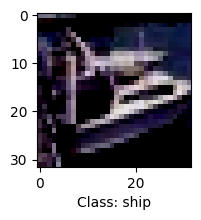

In [8]:
import matplotlib.pyplot as plt

def plot_sample(X, y, index):
    plt.figure(figsize=(15, 2))
    img = X[index].permute(1, 2, 0)  # 使用permute替代transpose
    plt.imshow(img)
    plt.xlabel(f"Class: {classes[y[index].item()]}")

# 调用这个函数
plot_sample(X_train, y_train, 10)



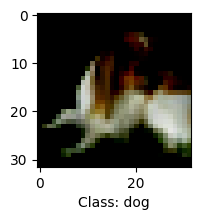

In [9]:
plot_sample(X_train, y_train, 1)

# ANN

In [10]:
from keras import models, layers

# 将 PyTorch 张量转换为 NumPy 数组
X_train_np = X_train.permute(0, 2, 3, 1).numpy()  # 调整维度顺序
y_train_np = y_train.numpy()

# 创建 Keras 模型
ann = models.Sequential([
    layers.Input(shape=(32, 32, 3)),  # 直接设置输入形状
    layers.Flatten(),
    # ... 其他层 ...
    layers.Dense(10, activation='softmax')    
])

# 编译模型
ann.compile(optimizer='SGD',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

# 在 NumPy 数组上训练模型
ann.fit(X_train_np, y_train_np, epochs=10)



Epoch 1/10
1563/1563 [==============================] - 5s 2ms/step - loss: 1.8789 - accuracy: 0.3431
Epoch 2/10
1563/1563 [==============================] - 4s 2ms/step - loss: 1.7929 - accuracy: 0.3803
Epoch 3/10
1563/1563 [==============================] - 4s 2ms/step - loss: 1.7670 - accuracy: 0.3937
Epoch 4/10
1563/1563 [==============================] - 4s 2ms/step - loss: 1.7519 - accuracy: 0.3973
Epoch 5/10
1563/1563 [==============================] - 4s 2ms/step - loss: 1.7435 - accuracy: 0.3998
Epoch 6/10
1563/1563 [==============================] - 4s 2ms/step - loss: 1.7354 - accuracy: 0.4038
Epoch 7/10
1563/1563 [==============================] - 4s 2ms/step - loss: 1.7288 - accuracy: 0.4069
Epoch 8/10
1563/1563 [==============================] - 4s 2ms/step - loss: 1.7246 - accuracy: 0.4068
Epoch 9/10
1563/1563 [==============================] - 4s 2ms/step - loss: 1.7197 - accuracy: 0.4098
Epoch 10/10
1563/1563 [==============================] - 4s 2ms/step - loss: 1.715

In [11]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# 调整 PyTorch 测试数据的维度顺序
X_test_permuted = X_test.permute(0, 2, 3, 1)

# 将 PyTorch 测试数据转换为 NumPy 数组
X_test_np = X_test_permuted.numpy()

# 使用 Keras 模型进行预测
y_pred = ann.predict(X_test_np)

# 获取预测类别
y_pred_classes = [np.argmax(element) for element in y_pred]

# 打印分类报告等信息
print("Classification Report:\n", classification_report(y_test, y_pred_classes))



313/313 [==============================] - 1s 1ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.56      0.49      1000
           1       0.41      0.51      0.45      1000
           2       0.32      0.24      0.27      1000
           3       0.28      0.25      0.26      1000
           4       0.38      0.36      0.37      1000
           5       0.30      0.35      0.32      1000
           6       0.41      0.40      0.40      1000
           7       0.45      0.46      0.45      1000
           8       0.50      0.48      0.49      1000
           9       0.48      0.40      0.44      1000

    accuracy                           0.40     10000
   macro avg       0.40      0.40      0.40     10000
weighted avg       0.40      0.40      0.40     10000



# CNN

In [12]:
cnn = models.Sequential([
    layers.Reshape((32, 32, 3)), 
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

In [13]:
cnn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
cnn.fit(X_train_np, y_train_np, epochs=10)

Epoch 1/10
1563/1563 [==============================] - 7s 3ms/step - loss: 1.4695 - accuracy: 0.4805
Epoch 2/10
1563/1563 [==============================] - 5s 3ms/step - loss: 1.2005 - accuracy: 0.5811
Epoch 3/10
1563/1563 [==============================] - 5s 3ms/step - loss: 1.0945 - accuracy: 0.6198
Epoch 4/10
1563/1563 [==============================] - 5s 3ms/step - loss: 1.0314 - accuracy: 0.6421
Epoch 5/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.9852 - accuracy: 0.6561
Epoch 6/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.9434 - accuracy: 0.6703
Epoch 7/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.9066 - accuracy: 0.6833
Epoch 8/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.8771 - accuracy: 0.6943
Epoch 9/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.8420 - accuracy: 0.7072
Epoch 10/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.817

In [15]:
y_test_np = y_test.detach().numpy()
print("ANN:")
ann.evaluate(X_test_np,y_test_np)
print("CNN:")
cnn.evaluate(X_test_np,y_test_np)
print("VGG:")
net.test(device)

ANN:
313/313 [==============================] - 1s 2ms/step - loss: 1.7437 - accuracy: 0.3988
CNN:
313/313 [==============================] - 1s 2ms/step - loss: 1.0750 - accuracy: 0.6320
VGG:
Accuracy of the network on the 10000 test images: 81.310 %


可以看出，ANN的精度在40%左右，CNN的精度在63%左右，VGG的精度在80%，显著提高